<b>Group 25:</b>
* Andrew Nee
* Nhi Tran
* Alex Kowalewski

<b>Question 1 — The DS Problem (2 points)</b>

* In your own words, formulate the Data Science problem.

Data Science problem: Does more traffic at the destination airports correlate to the departure delay, for top 20 most frequently traffic destination?

<b>Question 2 — Prepare the Data (8 pts)</b>

* Evaluate the dataset to determine if ALL variables are represented in their expected type. Convert variables to suitable data types (if needed).
* Analyze the data to determine what preprocessing steps are needed. Perform the required data preparation steps. At a minimum, ensure that you handle both missing and invalid values. Justify the approach that is taken to prepare the data for analysis.
* At a high level explain what the dataset is about and prepare at least three visualizations to support your explanation.
Note: this explanation should be relevant to the DS Problem in question 1.

In [1]:
# for google colab
# from google.colab import files
# uploaded = files.upload()

In [2]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

# for jupyter notebook:
df = pd.read_csv("2019_ONTIME_REPORTING_FSW.csv")
# df = pd.read_csv(io.StringIO(uploaded[
#    "2019_ONTIME_REPORTING_FSW.csv"].decode('utf-8')))
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828.0,0.0,1353.0,0.0,205.0,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907.0,0.0,2159.0,0.0,112.0,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904.0,104.0,2016.0,101.0,192.0,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729.0,4.0,2215.0,3.0,166.0,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656.0,0.0,841.0,0.0,285.0,1947


In [3]:
df.shape # 1897503 rows, 14 columns - correct number of columns
# check all values dtypes to see if they are in correct type
df.dtypes

FL_DATE          object
CARRIER_CODE     object
TAIL_NUM         object
FL_NUM            int64
ORIGIN           object
ORIGIN_ST        object
DEST             object
DEST_ST          object
DEP_TIME        float64
DEP_DELAY       float64
ARR_TIME        float64
ARR_DELAY       float64
ELAPSED_TIME    float64
DISTANCE          int64
dtype: object

### Data types and what can be changed:
- fl_date can be change to the datetime64
- Carrier_Code should be category
- fl_num should be str if wanted to concatenate with carrier_code
- tail_num is str
- Origin is category
- origin_st is category
- dest is category
- dest_st is category
- arr_time can be changed to timedelta (24 hours format)
- dep_time can be changed to timedelta (24 hours format)
- dep_delay and arr_delay will be keep as float for calculation
- elapsed_time and distance will also be keep as float (and int) for calculation

In [4]:
# but before we do all this, we should check for invalid and missing values, as
# sometimes they make converting values difficult
df.isnull().sum()

FL_DATE             0
CARRIER_CODE        0
TAIL_NUM         4791
FL_NUM              0
ORIGIN              0
ORIGIN_ST           0
DEST                0
DEST_ST             0
DEP_TIME        26707
DEP_DELAY       26715
ARR_TIME        28244
ARR_DELAY       31884
ELAPSED_TIME    31884
DISTANCE            0
dtype: int64

In [5]:
# for tail_num, we can't add the mode of the plane since that will be incorrect
# data --> delete it
df2 = df[df["TAIL_NUM"].notna()]

# check to see the frequency of missing values each row
df2.isnull().sum(axis = 1).sort_values(ascending = False) # missing at most 5
# the 5 missing values happened to be those that we will use a lot
# (quantitative data), so we might consider removing those that have 5
# missing values, for the remaining data, we might be able to try imputation
# remove row with more than 4 missing variables each row
df2 = df2[df2.isnull().sum(axis = 1) < 4]
# check again
df2.isnull().sum()

# elapsed_time and arr_delay most likely have the same missing variables as
# they have same # of missing values
# consider that we will use the data, it is best to just remove the missing
# values as it might affect how we calculate the (ex: avg arr_delay)
# if considering impute them, might need to consider which carrier, org to dest,
# to find the avg values
df2 = df2[df2["ELAPSED_TIME"].notna()]
df2.isnull().sum()

FL_DATE         0
CARRIER_CODE    0
TAIL_NUM        0
FL_NUM          0
ORIGIN          0
ORIGIN_ST       0
DEST            0
DEST_ST         0
DEP_TIME        0
DEP_DELAY       0
ARR_TIME        0
ARR_DELAY       0
ELAPSED_TIME    0
DISTANCE        0
dtype: int64

In [6]:
# now is working with invalid data , might not be able to view it just from
#df.shape and null
df2.describe()
# none of the quantitative columns are negative, which is good, they should not
#be negative.

categories = ["CARRIER_CODE", "ORIGIN", "ORIGIN_ST", "DEST", "DEST_ST"]

# make sure that the states and location are all uppercase
for cat in categories:
  df2[cat] = df2[cat].str.upper()
  df2[cat] = df2[cat].astype('category')

# now let's try to convert the variables into its desired types
df2["FL_DATE"] = pd.to_datetime(df2["FL_DATE"])
df2["FL_NUM"] = df2["FL_NUM"].astype(str)
df2["TAIL_NUM"] = df2["TAIL_NUM"].astype(str)
df2["ARR_TIME"] = pd.to_timedelta(df2["ARR_TIME"], unit = "s")
df2["DEP_TIME"] = pd.to_timedelta(df2["DEP_TIME"], unit = "s")

# check the new data type
df2.dtypes
# the object is string, dtype object but the class is string
# if check by type(df2["TAIL_NUM"][0]) it will return str

FL_DATE          datetime64[ns]
CARRIER_CODE           category
TAIL_NUM                 object
FL_NUM                   object
ORIGIN                 category
ORIGIN_ST              category
DEST                   category
DEST_ST                category
DEP_TIME        timedelta64[ns]
DEP_DELAY               float64
ARR_TIME        timedelta64[ns]
ARR_DELAY               float64
ELAPSED_TIME            float64
DISTANCE                  int64
dtype: object

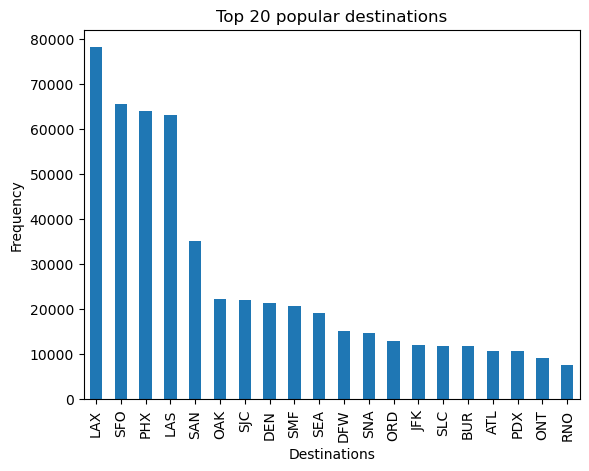

In [7]:
# start analyze our DS problem
# before that, let's get rows where arr_delay > 0, to include delayed planes
df3 = df2[df2["DEP_DELAY"] > 0]
# let's look at the top 20 most travelled destinations overall, expected a lot
# in the east coast because popularity
# not only domestically but also internationally (i.e. have Disney Land)
df3["DEST"].value_counts().head(20).plot(kind = "bar", xlabel = "Destinations",
                                         ylabel = "Frequency")
plt.title("Top 20 popular destinations")
plt.show()

/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/1728717699.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_dest = df3.groupby(["DEST"])
/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/1728717699.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (x[i], y[i]+1))


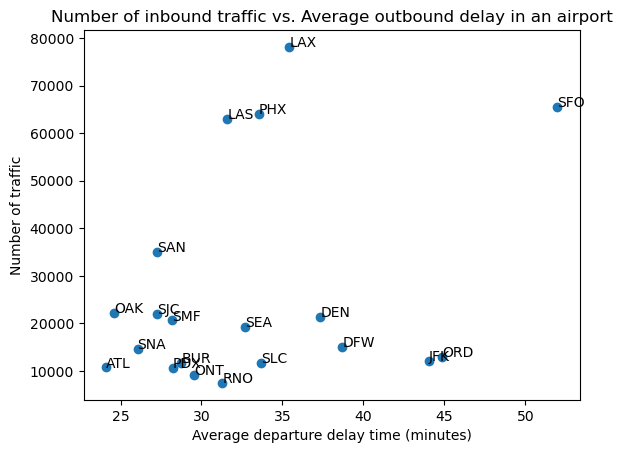

In [8]:
# let's find if arrival delay related to top 20 most common destinations
get_20 = df3["DEST"].value_counts().head(20) # pd.series
group_dest = df3.groupby(["DEST"])
mean_delay_by_dest = group_dest["DEP_DELAY"].mean()
# determine x and y
y = get_20
x = mean_delay_by_dest[list(get_20.index)]
# set label and provide annotation
label = list(get_20.index)
fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(label):
    ax.annotate(txt, (x[i], y[i]+1))
plt.title("Number of inbound traffic vs. Average outbound delay in an airport")
plt.xlabel("Average departure delay time (minutes)")
plt.ylabel("Number of traffic")
plt.show()

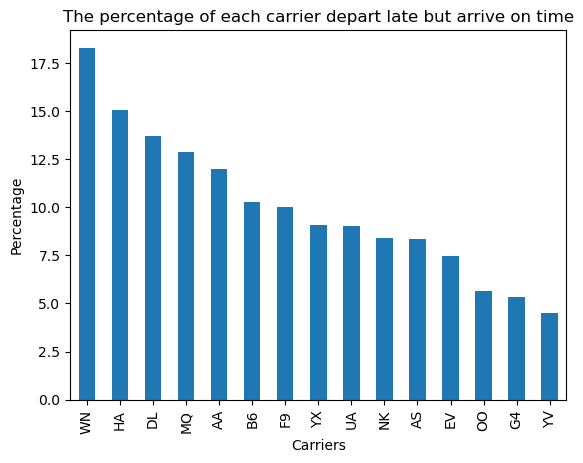

In [9]:
# then, lets think about how many times each airline, they depart late but they
# arrive on time perhaps we can determine which one is
# more reliable, as in even if they departed late, it will arrive on time
# Ensure CARRIER_CODE is category
df2["CARRIER_CODE"] = df2["CARRIER_CODE"].astype('category')

# Filter for flights that departed late but arrived on time
df4 = df2[(df2["DEP_DELAY"] > 0) & (df2["ARR_DELAY"] == 0)]

# Group by CARRIER_CODE and count occurrences
group_carriers = df4["CARRIER_CODE"].value_counts()
total_flights = df2["CARRIER_CODE"].value_counts()

# Calculate the percentage
wanted = (group_carriers / total_flights) * 100

# Sort and plot the values
ax = wanted.sort_values(ascending=False).plot(kind="bar",
                                         xlabel="Carriers",
                                         ylabel="Percentage")
plt.title("The percentage of each carrier depart late but arrive on time")
plt.show()

The dataset is the record of all domestic USA flights in 2019. It tracks flight data such as how long the flight was in time and distance, when and where it departed from and where it arrived. It also has info on the plane such as airline, tail, flight number.

Based on our data science question, we found out that LAX, SFO, PHX, and LAS are significantly higher in term of traffic than any other destinations (all more than half). Putting aside the fact that lots of people come to California (LAX, SFO, LAS) for tourists area, these airports also go international. Lots came to these airports to travel to a different country, thus, it makes sense why they have large amount of traffic.

As we can see, even without a linear regression line, there is no correlation between number of traffic at an airport and the average arrival delay in that airport. It is true that the more concentrated an airport (destination), the more likely for delay to occur, as there are more air traffic, less place to park the planes, as well as potential malfunction or issue with the passengers on the plane that caused the plane to not leave on time for the arrival planes. However, this only give the big picture, the airlines could have been the reason why there are no trend as some tend to delay more than others, making the average arrival delay perhaps not represent the entire airport accurately.

From the last visualization, we can see that some carriers arrive on time despite departing late. This is important to notice because we analyze average departure delays in these big airports. However, just because it got delayed does not mean they cannot arrive on time. This is how the airport did not get congested, and every airplanes were delayed. So, if you were to be at these airports that have high departure delays time, they do not always mean that you will be late for your destination. Additional information we can learn was that WN has the highest percentage of depart late but arrive on time. Our previous analysis and graph lacked the nuance that departing late does not always mean that you will arrive at the destination late. So, even if there is a correlation, we cannot conclude and assume that in highly traffic airport, the passengers will get to their destination late, because chances are the passengers would still make it on time. Thus, there is no reason to avoid certain airports just because they have higher average delay time. On another note, with this information and the fact that WN price tend to be cheaper, WN carriers could be suggested for customers who want cheaper price and higher chance of arrive on time despite departing late. The percentage is low but at least it is the highest across all carriers.

<b>Question 3 — (20 points)</b>

* Explore patterns in the region i.e. the 3 states (AZ, NV, CA). Determine which region has the most air traffic. Comment on your findings and visualize the results.
* For each region, analyze the most popular outbound/destination airports. For example, if a flight originated in CA (at any of its airports), where do they often go? Comment on your findings and visualize the top 5 results.

In [10]:
#for this question let's just keep the state that we want (departed from AZ, NV,
# CA)
wanted_df = df2[df2["ORIGIN_ST"].isin(["AZ", "NV", "CA"])]
wanted_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,0 days 00:13:48,0.0,0 days 00:22:33,0.0,205.0,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,0 days 00:31:47,0.0,0 days 00:35:59,0.0,112.0,602
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,0 days 00:28:49,4.0,0 days 00:36:55,3.0,166.0,1205
5,2019-10-01,AA,N816NN,2339,PHX,AZ,JFK,NY,0 days 00:15:11,0.0,0 days 00:28:22,0.0,291.0,2153
6,2019-10-01,AA,N150NN,2349,LAX,CA,BOS,MA,0 days 00:35:49,0.0,0 days 00:09:19,0.0,310.0,2611


<i> Question 3 Part 1 </i>

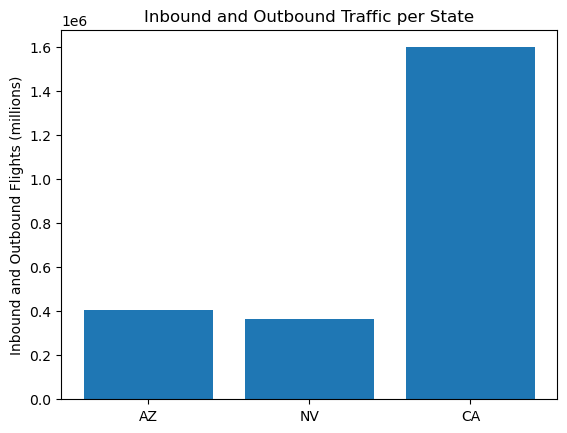

In [11]:
%matplotlib inline

reg = ["AZ","NV","CA"]

traffic = []

for state in reg:
  traffic.append((df2 == state).sum().sum())

plt.bar(reg, traffic)
plt.title("Inbound and Outbound Traffic per State")
plt.ylabel("Inbound and Outbound Flights (millions)")
plt.show()

California total traffic (inbound and outbound) is significantly higher than both Arizona and Nevada. They are similar in traffic with Arizona slightly edging out Nevada. This makes sense as not only the population of California significnatly higher than the other two states, but California is one of the most popular destination spots for business and vacations.

Additionally, despite Nevada having less half of the population of Arizona, they have similar traffic. I suspect this is beacuse of the Las Vegas being one of the most popular places to visit.

<i> Question 3 Part 2 </i>

In [12]:
# values of total traffic (AZ, NV, CA)
traffic = []
for state in reg:
  traffic.append((df2 == state).sum().sum())

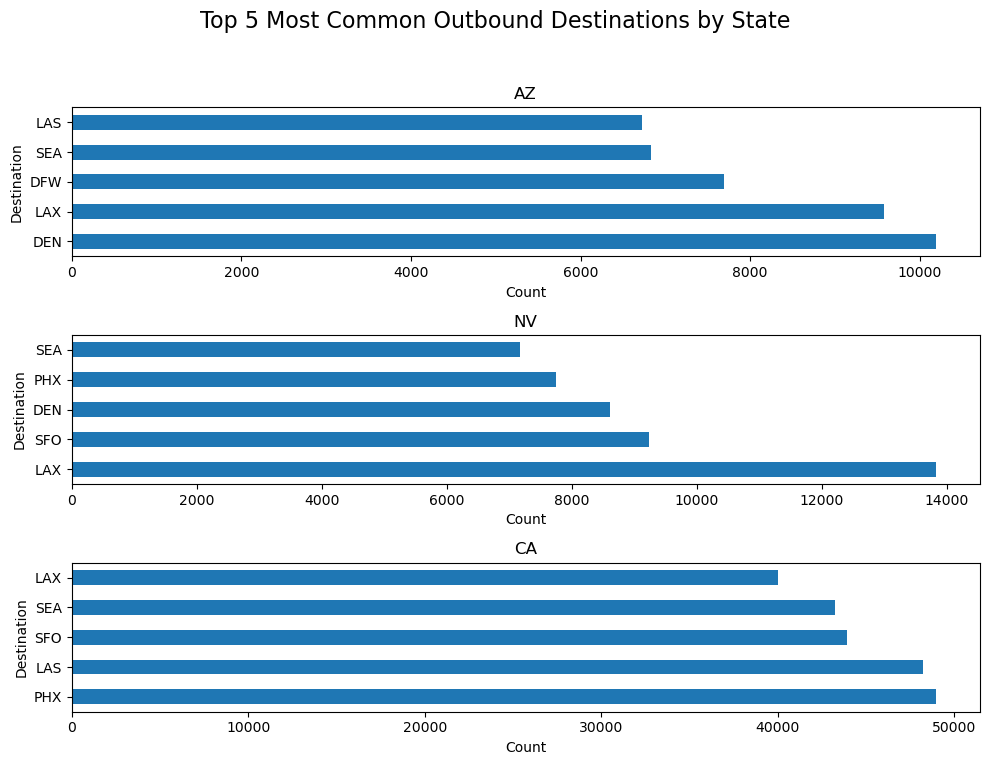

In [13]:
# List of states to analyze
states = ['AZ', 'NV', 'CA']

# Dictionary to hold the dataframes and top destinations for each state
state_dfs = {}
state_dest_counts = {}

# Create state-specific dataframes and get the top 5 destination counts
for state in states:
    state_dfs[state] = wanted_df.loc[wanted_df['ORIGIN_ST'] == state]
    state_dest_counts[state] = state_dfs[state]['DEST'].value_counts()[:5]

# Create subplots
fig, axes = plt.subplots(nrows=len(states), figsize=(10, 8))

# Plot the data
for i, state in enumerate(states):
    state_dest_counts[state].plot(kind='barh', ax=axes[i])
    axes[i].set_title(state)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Destination')

# Set the overall title and adjust layout
fig.suptitle("Top 5 Most Common Outbound Destinations by State", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()


All 3 states include each other state in their top 5 most common outbound destination. This is not surprising as all of the states are geographical neighbors.

Interestingly, some of the most common outbound destination in California are LAX and SFO, both being in California. On the other hand, neither Nevada nor Arizona share this trait.

Our suspection about Las Vegas being one of the reasons why Nevada and Arizona have similar traffic is verified by both LAS and PHX having similar inbound traffic from California.

<b>Question 4 — (20 points)</b>

* Explore the carriers. Calculate the proportion of flights for each airline/operator. Visualize the top 10 results. Explain the results.
* Analyze the flight delays for each Airline/Carrier and prepare summary statistics to explain the patterns in the delays. Visualize the results. Explain the patterns and demonstrate which carriers are more prone to flight delays.
** Note: you will need to analyze the airlines/carriers across multiple airports in order to conclude that they have a pattern of being late.

<i> Question 4 Part 1 </i>

Text(0, 0.5, '')

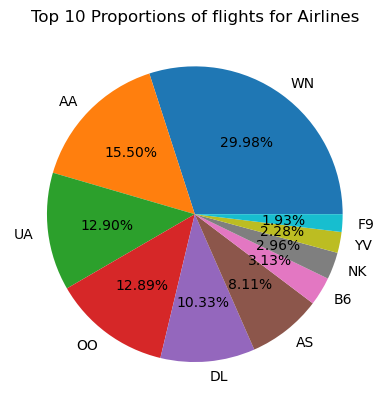

In [14]:
# counts carrier codes, then gets the top 10 and normalizes
carrier = df2['CARRIER_CODE'].value_counts()
top_car = carrier[:10]
prop_car = top_car/top_car.sum()

prop_car.plot(kind='pie', autopct='%.2f%%')
plt.title("Top 10 Proportions of flights for Airlines")
plt.ylabel('')

South West Airlines have the highest proportion of flights (almost 1/3 of the total
number of flights in 2019). This is understandable as South West airlines have
a relatively cheaper price compare with other traditional airlines. The other
big airlines such as American Airlines (AA), United Airlines (UA), and Delta(DL) have good reputations and a general competitive price, thus it makes sense that they hold a large portion of the proportion of flights as well. Sky West airline (OO) has the second largest proportion because not only it is one of the biggest regional airline, it also operated on the behalf of other airlines as well.


<i> Question 4 Part 2 </i>

In [15]:
# Then, we try to find the pattern of delay by specify these conditions
# we specified the condition because we want to make sure that the avg arrival
# delay time will not include flight that did not arrive late as it could
# affect our average (make the average lower, even though if they were to be
# delayed, the delay time is higher)
# First, lets just get all delay time that is NOT 0 (have_delay)
have_delay = df2[df2["ARR_DELAY"] > 0]
have_delay_group = have_delay.groupby(["CARRIER_CODE"])
# Then, get all no-delay time ( == 0)
no_delay = df2[df2["ARR_DELAY"] == 0]
no_delay_group = no_delay.groupby(["CARRIER_CODE"])
# lastly, get the total amount of flights for each carriers
total_flight = df2.groupby(["CARRIER_CODE"])
length_carriers = total_flight["CARRIER_CODE"].count()

# count and mean are more important - mean can show us the average delay time,
# while count can help us determine the percentages of
# delay happened over all flights in 2019
print("Mean of each carriers for all delays flight \n",
      have_delay_group["ARR_DELAY"].mean().sort_values(ascending = False).round(2))
no_delay_pct = (( no_delay_group["ARR_DELAY"].count() / length_carriers ) * 100).round(2)
delay_pct = (( have_delay_group["ARR_DELAY"].count() / length_carriers ) * 100).round(2)

/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/3678392082.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  have_delay_group = have_delay.groupby(["CARRIER_CODE"])
/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/3678392082.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_delay_group = no_delay.groupby(["CARRIER_CODE"])
/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/3678392082.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

Mean of each carriers for all delays flight 
 CARRIER_CODE
YX    67.33
B6    48.26
OO    48.04
F9    45.22
YV    44.90
UA    44.33
EV    42.93
NK    39.93
AA    38.59
G4    35.91
DL    32.90
AS    31.85
MQ    30.49
WN    27.38
HA    25.73
Name: ARR_DELAY, dtype: float64


It looks like YX carrier has the highest mean arrival delay time. WN carriers seem to have the lowest mean arrival delay time.

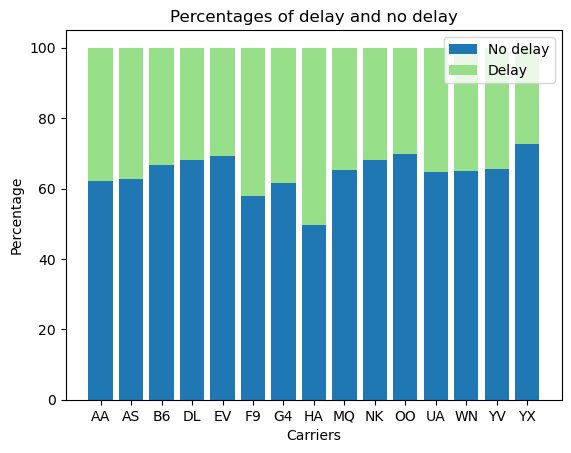

In [16]:
# make the stacked bar chart for delay and no delay for each carriers
# with this we can see which airlines tend to have delay over all of their
# flights in 2019
x = delay_pct.index
y1 = no_delay_pct
y2 = delay_pct
plt.bar(x, y1, color = "#1F77B4")
plt.bar(x, y2, bottom = y1, color = "#98DF8A")
plt.legend(["No delay", "Delay"])
plt.title("Percentages of delay and no delay")
plt.xlabel("Carriers")
plt.ylabel("Percentage")
plt.show()

For most airlines, all have over 50% no delay for all flights in 2019. Most of them have a similar percentage of no delay. According to this stacked bar chart, HA (Hawaiian Airline) carriers have the lowest percentage of having no delay; this mean that this airline tends to be delayed (more delays on average). However, it is worth noticing that Haiwaiin airline does not have as many flights as the other airlines and maybe not as big, thus, making it more difficult to them in term of expenses to ensure that the flights will arrive on time.

<i> Question 4 Part 2 continued </i>

Lastly, we can compare percentage of delays (better than frequency of delays
because some airlines have significantly higher number of flights) vs. mean
delays time. This would help us and perhaps even the passengers to visualize what are the chance the flight will be delay and for how long (the average arrival delay time given that the flight were delayed)

/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/1014369853.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (x[i]+0.2, y[i]+0.2))


Text(0, 0.5, 'Percentage of delays')

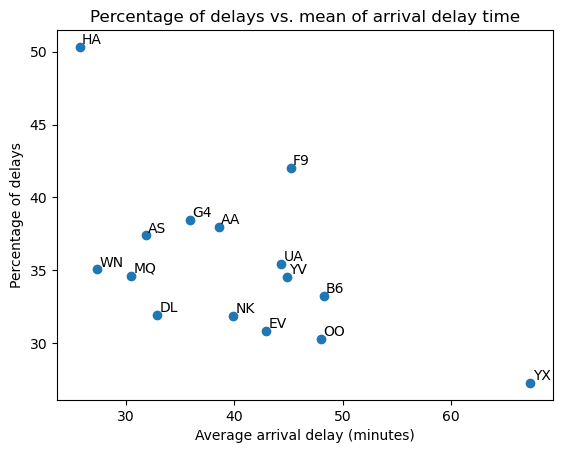

In [17]:
# compare percentage of delays (better than frequency of delays because some
# airlines have significantly higher number of flights) vs. mean delays time
x = have_delay_group["ARR_DELAY"].mean()
y = delay_pct
label = list(length_carriers.index)
fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(label):
    ax.annotate(txt, (x[i]+0.2, y[i]+0.2))

plt.title("Percentage of delays vs. mean of arrival delay time")
plt.xlabel("Average arrival delay (minutes)")
plt.ylabel("Percentage of delays")

Hawaiin airline (HA) has the highest percentage of delays, but also have a relatively short delays time. Republic Airways (YX) has the least percentage of delays, but their average arrival delays is very high (over an hour). Big airlines such as WN, AA, UA, DL also have a relatively common percentage of delays (around 32% to 38%) with the exception of DL having a lower percentage of delays (<35%). Out of the the top 4 big airlines, UA has the highest average arrival delay, WN has second highest percentage of delays, but with short average arrival delay time. Therefore, there are 2 extreme: HA highest percentage of delays, but shorter arrival delay time, and YX with lowest percentage of delay, but when they do get delayed, the average arrival delay is very high.

In a way, passenger can think as follow, in 2019 HA has approximately 50% delay, which mean that there could be a 1/2 chance that the flight with HA will be delayed, but they would not arrive too late to their destination as HA has the shortest arrival delay (for all delayed flight, not including no delay flight). Based on this, passenger can consider which airline they should take. Although there is no correlation, they can try to think of these percentage as chance of being delayed and for how long; it is not a definite that the flight will be delay and the exact arrival delay time, but passenger can use it as a benchmark and decide.

<b>Question 5 — (30 points)</b>

* Evaluate which airlines have the best record. Display the top 10.
* For each airline, ensure that you calculate their total flight hours for each month. Explain and visualize the results for the top 10 airlines.
Hint: the total flight hours is not equivalent to the frequency of flights, and ensure that you display the total hours and not the total minutes.

<i> Question 5 Part 1 </i>

/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/2549043819.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_airlines = df2.groupby('CARRIER_CODE')['ARR_DELAY'].mean().nsmallest(10)


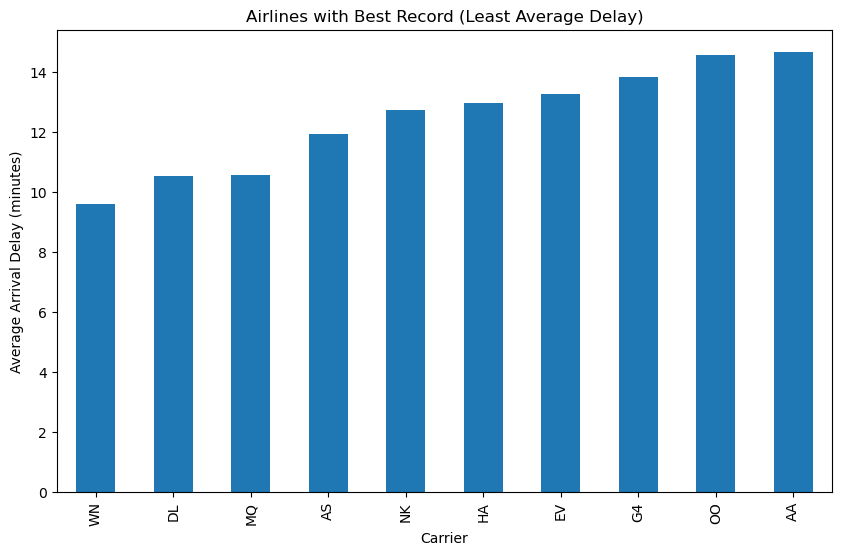

In [18]:
df2["CARRIER_CODE"] = df2["CARRIER_CODE"].astype('category')

# For this we use w/o specified the condition of delay because we want to see
# the trend of the airlines with all of the flights and not just flights that
# are delayed or not delayed
# Best record based on least average delay
best_airlines = df2.groupby('CARRIER_CODE')['ARR_DELAY'].mean().nsmallest(10)

# Convert best_airlines to a DataFrame
best_airlines_df = best_airlines.reset_index()

plt.figure(figsize=(10, 6))
best_airlines.plot(kind='bar')
plt.title('Airlines with Best Record (Least Average Delay)')
plt.xlabel('Carrier')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()

Airlines with the best records are those that have the least average arrival delay time. WN (South West Airline) have the least average arrival delay time with DL comes close second, which was expected from the previous graph of percentage of delays vs. arrival delay time. The big 3 airlines (WN, AA, DL) all are in the top 10 airlines with the best record besides United (UA), although in general, they are not the best at having short arrival delay time.

<i> Question 5 Part 2 </i>

/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/7186201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_df['MONTH'] = top_10_df['MONTH'].astype('category')
/var/folders/k6/nb8wqh3n7mg1xlpks6qhbqwm0000gn/T/ipykernel_1709/7186201.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_flight_hours = top_10_df.groupby([


<Figure size 1400x800 with 0 Axes>

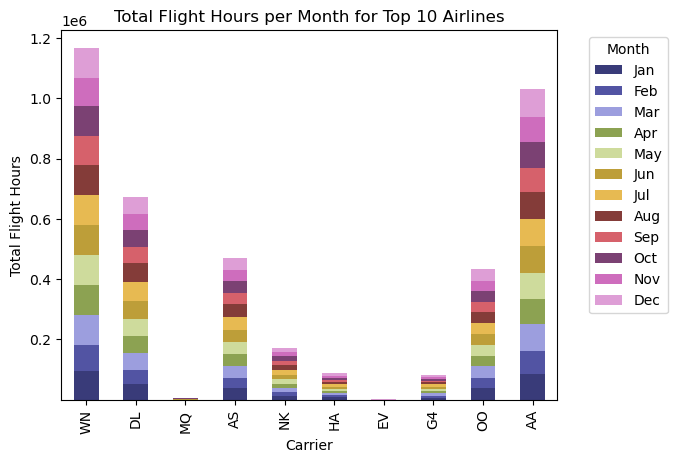

In [19]:
import calendar

# Convert elapsed time from minutes to hours
df2['FLIGHT_HOURS'] = df2['ELAPSED_TIME'] / 60

# Extract month from flight date
df2['MONTH'] = df2['FL_DATE'].dt.month

# Filter the DataFrame to include only the top 10 airlines
top_10_df = df2[df2["CARRIER_CODE"].isin(best_airlines.index)]

# Ensure 'MONTH' is a category as well
top_10_df['MONTH'] = top_10_df['MONTH'].astype('category')

# Total flight hours per carrier per month
total_flight_hours = top_10_df.groupby([
    'CARRIER_CODE', 'MONTH'])['FLIGHT_HOURS'].sum().unstack()

# Ensure the columns are sorted properly
total_flight_hours = total_flight_hours.reindex(
    columns=range(1, 13), fill_value=0)
total_flight_hours.columns = [
    calendar.month_abbr[i] for i in total_flight_hours.columns]

plt.figure(figsize=(14, 8))
color_map = plt.get_cmap('tab20b', 12)
colors = [color_map(i) for i in range(12)]

total_flight_hours.loc[best_airlines.index].plot(kind='bar',
                                                 stacked=True, color=colors)
plt.title('Total Flight Hours per Month for Top 10 Airlines')
plt.xlabel('Carrier')
plt.ylabel('Total Flight Hours')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

WN has the most flights hours in total, follow by WN, AA and then DL. These 3 are in the top 4 airlines, thus, it was expected that they have high flight hours compared with others. For all airlines in the top 10, it seems like the distributions for the hours flight each month are consistent. There doesn't seem to be any more flight in particular any month than other, which was unexpected. For example, around the end of year (November and December), we would expected more flight since more people leave to travel, but that was not the case. It also seems like in February there are less flight time since the block looks slightly smaller. Additionally, 7 carriers that have less flights hours seem to do well for their arrival delay time (in the middle of top 10). There are 5 carriers that have significantly smaller flight time (MQ, NK, HA, EV, and G4) seems to have better average arrival delay time compared to AA and OO that have higher flight time. For MQ especially, they have low average arrival delay, but very little flight time. Perhaps they don't flight out as much, or the majority of their flights are short flight. Due to these reasons, they could have shorter arrival delay (EX: shorter flight, so can fly faster and has shorter arrival delay).

<b>Question 6 — (20 points)</b>

* Select any (3) aircraft, and explore the data to determine where it often travels. Calculate its average arrival and departure delays at the airports. After which analyze all the results to identify any patterns that are evident and also indicate which airline operates that aircraft. Explain your findings and visualize the results.
Note: the TAIL_NUM can help you to identify each unique aircraft.

In [20]:
np.random.seed(42)

# Select three random aircraft
random_aircrafts = np.random.choice(df2['TAIL_NUM'].unique(), size=3,
                                    replace=False)
print(random_aircrafts)

['N551AS' 'N393HA' 'N632VA']


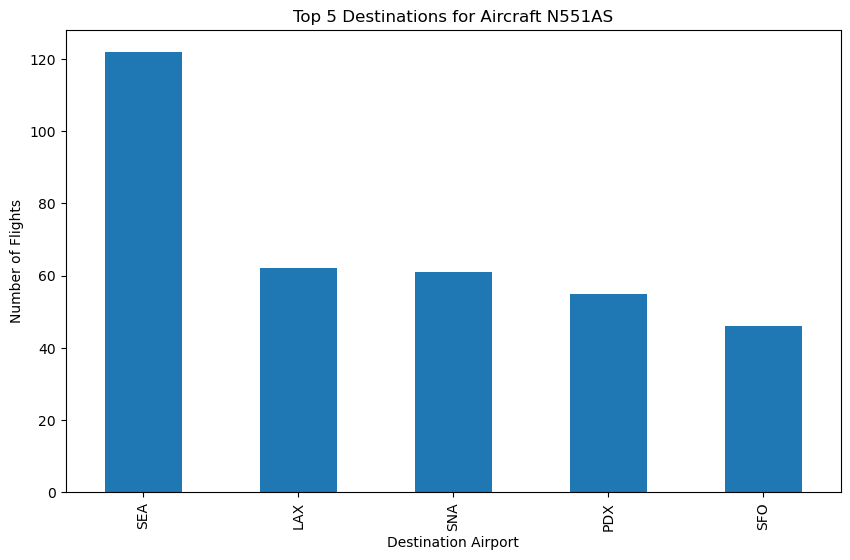

Carrier Code for Aircraft N551AS: AS
Average Delays for Aircraft N551AS at Top 5 Destinations:
Destination: SEA
DEP_DELAY    6.13
ARR_DELAY    7.57
dtype: float64
----------------------------------------
Destination: LAX
DEP_DELAY     7.31
ARR_DELAY    10.95
dtype: float64
----------------------------------------
Destination: SNA
DEP_DELAY    4.23
ARR_DELAY    3.98
dtype: float64
----------------------------------------
Destination: PDX
DEP_DELAY    5.04
ARR_DELAY    5.38
dtype: float64
----------------------------------------
Destination: SFO
DEP_DELAY    14.26
ARR_DELAY    15.37
dtype: float64
----------------------------------------


<Figure size 1000x600 with 0 Axes>

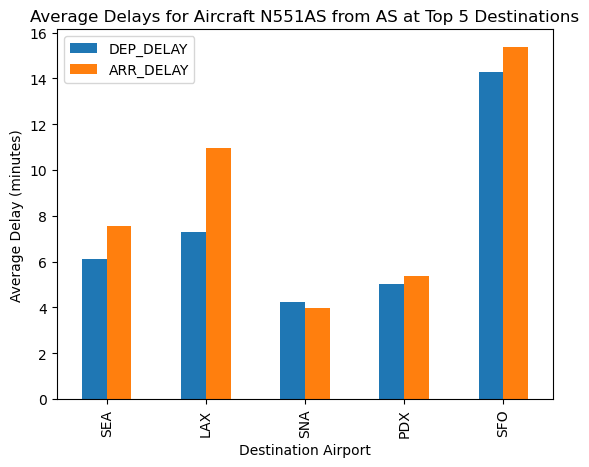

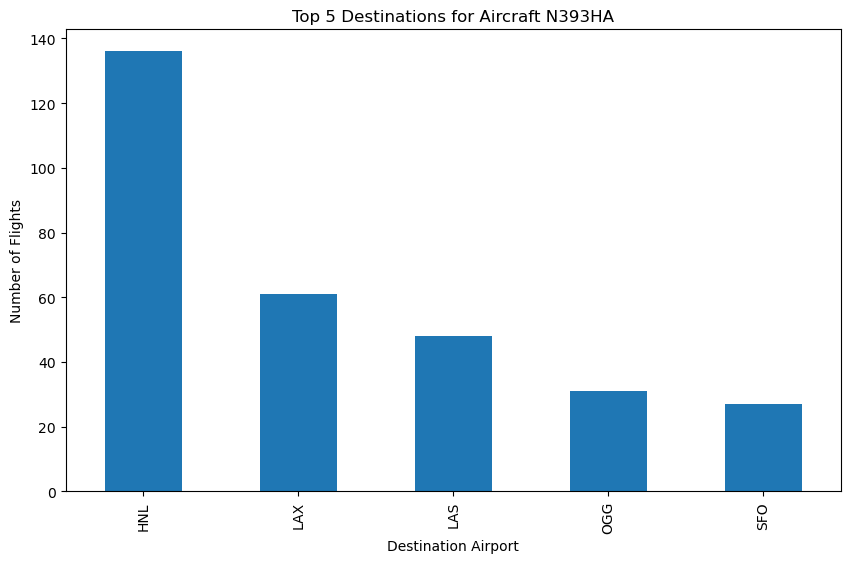

Carrier Code for Aircraft N393HA: HA
Average Delays for Aircraft N393HA at Top 5 Destinations:
Destination: HNL
DEP_DELAY    11.40
ARR_DELAY    14.01
dtype: float64
----------------------------------------
Destination: LAX
DEP_DELAY    4.72
ARR_DELAY    7.69
dtype: float64
----------------------------------------
Destination: LAS
DEP_DELAY    14.54
ARR_DELAY    13.71
dtype: float64
----------------------------------------
Destination: OGG
DEP_DELAY    3.84
ARR_DELAY    7.94
dtype: float64
----------------------------------------
Destination: SFO
DEP_DELAY    8.07
ARR_DELAY    7.85
dtype: float64
----------------------------------------


<Figure size 1000x600 with 0 Axes>

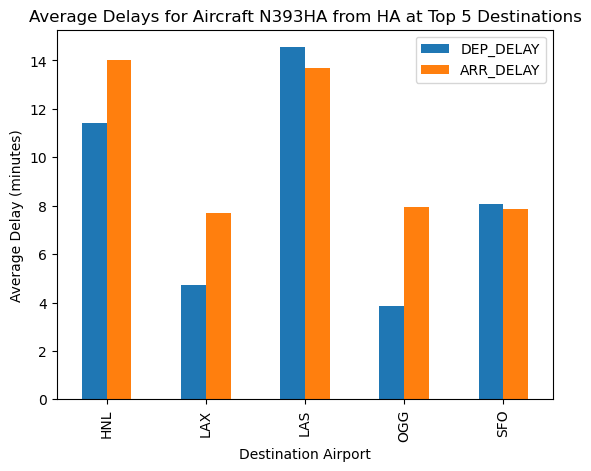

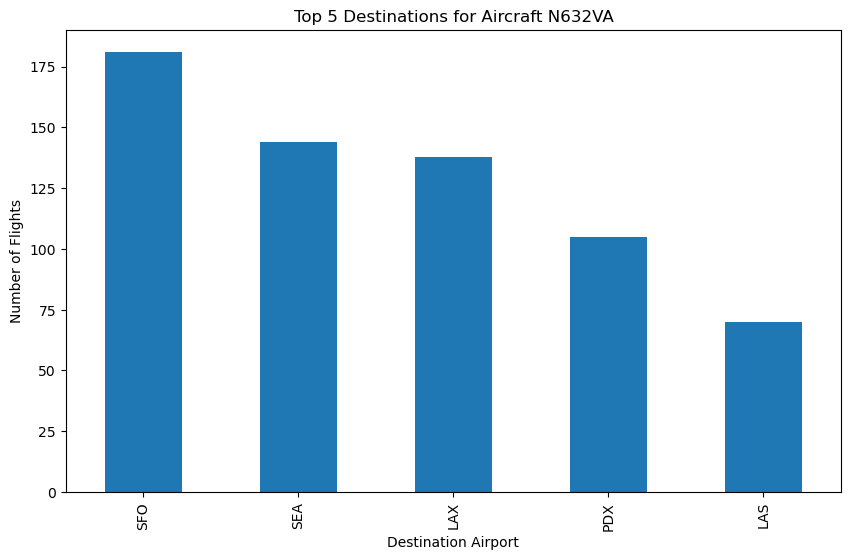

Carrier Code for Aircraft N632VA: AS
Average Delays for Aircraft N632VA at Top 5 Destinations:
Destination: SFO
DEP_DELAY    19.38
ARR_DELAY    22.15
dtype: float64
----------------------------------------
Destination: SEA
DEP_DELAY    11.45
ARR_DELAY    14.58
dtype: float64
----------------------------------------
Destination: LAX
DEP_DELAY    8.86
ARR_DELAY    9.59
dtype: float64
----------------------------------------
Destination: PDX
DEP_DELAY     9.33
ARR_DELAY    11.02
dtype: float64
----------------------------------------
Destination: LAS
DEP_DELAY     8.77
ARR_DELAY    12.41
dtype: float64
----------------------------------------


<Figure size 1000x600 with 0 Axes>

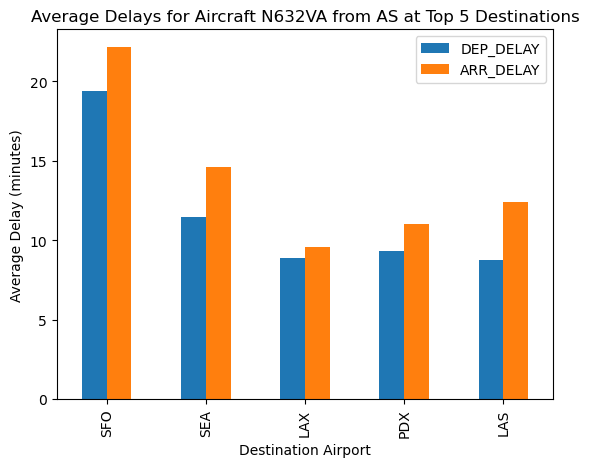

In [21]:
# Analyze travel patterns and delays
for aircraft in random_aircrafts:
    aircraft_data = df2[df2['TAIL_NUM'] == aircraft]
    popular_destinations = aircraft_data['DEST'].value_counts().head(5)
    carrier_code = aircraft_data['CARRIER_CODE'].unique()[0]

    # Plot top 5 destinations
    plt.figure(figsize=(10, 6))
    popular_destinations.plot(kind='bar')
    plt.title(f'Top 5 Destinations for Aircraft {aircraft}')
    plt.xlabel('Destination Airport')
    plt.ylabel('Number of Flights')
    plt.show()

    print(f'Carrier Code for Aircraft {aircraft}: {carrier_code}')
    print(f'Average Delays for Aircraft {aircraft} at Top 5 Destinations:')

    # Calculate average delays for each of the top 5 destinations
    avg_delays_list = []
    destinations = []
    for destination in popular_destinations.index:
        destination_data = aircraft_data[aircraft_data['DEST'] == destination]
        avg_delays = destination_data[['DEP_DELAY', 'ARR_DELAY']].mean()
        avg_delays_list.append(avg_delays)
        destinations.append(destination)
        print(f'Destination: {destination}')
        print(round(avg_delays, 2))
        print('-' * 40)

    # Create a dataframe for better visualization of average delays
    avg_delays_df = pd.DataFrame(avg_delays_list, index=destinations)

    plt.figure(figsize=(10, 6))
    avg_delays_df.plot(kind='bar')
    plt.title(f'Average Delays for Aircraft {aircraft} from {carrier_code} at'
    f' Top 5 Destinations')
    plt.xlabel('Destination Airport')
    plt.ylabel('Average Delay (minutes)')
    plt.show()
    print()


All of the top 5 destinations for aircraft visualizations make sense. For example, Hawaiian Airlines having HNL and OGG airports, both Hawaiian airports, in the their top 5 is unsurprising. Additionally, for Alaska Airlines, having all West coast/Pacific Northwest airports makes sense for the same logic. In all of the visualizations, we can see popular airports such as SEA, LAX, SFO, LAS, and PDX show up often. Interestingly, it seems like SFO always has high, even in HA, where it is the 5th most common destination.

The delay times aligned up sometime, for example, for N632VA as LAS, the approximate delay time is 10 - 13 minutes, which aligned with N393HA (~14 minutes). LAX delay is also relatively consistent across all 3 aircraft (N551AS ~8 to 11 minutes, N393HA ~5 to 8 minutes, N632VA ~9 to 10 minutes). It is consistent in a way that it does not exceed 11 minutes. Therefore, there is some consistency across airports. Still, many other factors (perhaps not even the airport itself but the passengers that caused issue) need to be considered before deciding that these certain airports tend to have average certain minutes of delay times.